In [15]:
import os
import numpy as np
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, GlobalAveragePooling1D, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

import glob
import pickle
np.random.seed(10) 
import random
random.seed(10)

In [16]:
# Load and preprocess data
def load_data(file_paths):
    texts = []
    for file_path in file_paths:
        with open(file_path, 'r') as f:
            texts.append(f.read())
    return texts

In [17]:
class1_files = glob.glob("upselling_masked_data/*/upselling/*.txt")  # Array of file paths for class 1
class2_files = glob.glob("upselling_masked_data/*/not_upselling/*.txt")  # Array of file paths for class 2

In [18]:
class1_files=[]
class2_files=[]

train_upsell=glob.glob('upselling_masked_data/training/upselling/*.txt')
valid_upsell=glob.glob('upselling_masked_data/validation/upselling/*.txt')
test_upsell=glob.glob('upselling_masked_data/testing_balanced/upselling/*.txt')

train_not_upsell=glob.glob('upselling_masked_data/training/not_upselling/*.txt')
valid_not_upsell=glob.glob('upselling_masked_data/validation/not_upselling/*.txt')
test_not_upsell=glob.glob('upselling_masked_data/testing_balanced/not_upselling/*.txt')


print(len(train_upsell),len(valid_upsell),len(test_upsell))
print(len(train_not_upsell),len(valid_not_upsell),len(test_not_upsell))

523 120 137
523 120 137


In [19]:
class1_files.extend(train_upsell)
class1_files.extend(valid_upsell)

class2_files.extend(train_not_upsell)
class2_files.extend(valid_not_upsell)

print(len(class1_files))
print(len(class2_files))

643
643


2023-04-15 20:32:13.677654: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 20:32:15.291616: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7858 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0893:00:00.0, compute capability: 7.5
2023-04-15 20:32:15.293026: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 357 MB memory:  -> device: 1, name: Tesla T4, pci bus id: a490:00:00.0, compute capability: 7.5


Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-04-15 20:32:18.840728: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


33/33 [==============================] - ETA: 0s - loss: 0.6195 - acc: 0.6673WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f5b98696a70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
33/33 [==============================] - 6s 95ms/step - loss: 0.6195 - acc: 0.6673 - val_loss: 1.7219 - val_acc: 0.0581
Epoch 2/30
33/33 [==============

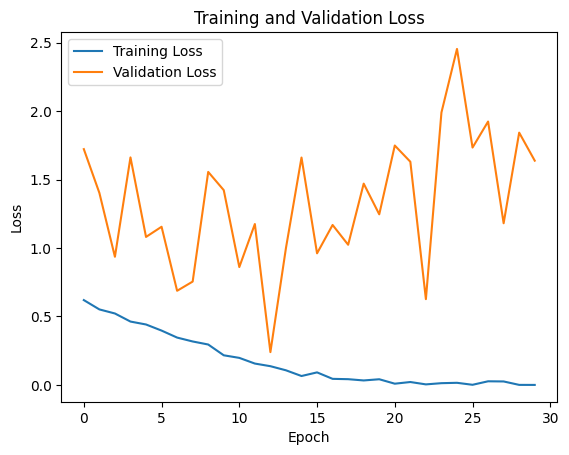

In [7]:
import numpy as np
import os
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Input, LSTM, Dense
from keras.models import Model

# Define paths to the files for the two classes


# Combine the two sets of files into a single list
all_files = class1_files + class2_files

# Read in the text from the files and combine into a single list
texts = []
for file in all_files:
    with open(file, "r") as f:
        text = f.read()
        texts.append(text)

# Set the maximum number of words in the vocabulary
max_words = 10000

# Tokenize the text and convert to sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Determine the maximum length of a sequence
maxlen = max(len(seq) for seq in sequences)

# Pad the sequences to have the same length
data = pad_sequences(sequences, maxlen=maxlen)

# Define the path to the GloVe embedding file
glove_path = "glove.6B.300d.txt"

# Load the embedding file into a dictionary
embeddings_index = {}
with open(glove_path) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create an embedding matrix that maps words to their corresponding GloVe vectors
embedding_dim = 300
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Define the model architecture
embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True)
sequence_input = Input(shape=(maxlen,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = LSTM(128)(embedded_sequences)
x = Dense(128, activation='relu')(x)
preds = Dense(1, activation='sigmoid')(x)
model = Model(sequence_input, preds)

checkpoint = ModelCheckpoint('glove_model/best_weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=False, mode='min')


# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

# Define the labels for the data (0 for class1, 1 for class2)
labels = np.concatenate([np.zeros(len(class1_files)),
                          np.ones(len(class2_files))])

# Train the model
history = model.fit(data, labels, validation_split=0.2, epochs=30, batch_size=32,callbacks=[checkpoint])

# Plot the training and validation loss over time
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

model.save('glove_model/my_model.h5')
with open('glove_model/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    


In [20]:
import numpy as np
import os
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Input, LSTM, Dense
from keras.models import Model

# Define paths to the files for the two classes


# Combine the two sets of files into a single list
all_files = class1_files + class2_files

# Read in the text from the files and combine into a single list
texts = []
for file in all_files:
    with open(file, "r") as f:
        text = f.read()
        texts.append(text)

# Set the maximum number of words in the vocabulary
max_words = 10000

# Tokenize the text and convert to sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
maxlen = max(len(seq) for seq in sequences)

# Pad the sequences to have the same length
data = pad_sequences(sequences, maxlen=maxlen)

# Determine the maximum length of a sequence

In [21]:
import pickle
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Save the model and tokenizer to dis
# Load the model and tokenizer from disk

from keras.models import load_model
# model = load_model('glove_model/best_weights.h5')
model = load_model('glove_model/my_model.h5')

with open('glove_model/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Load the testing data and labels
test_files_class1 = test_upsell
test_files_class2 = test_not_upsell
test_texts_class1 = []
for file in test_files_class1:
    with open(file, "r") as f:
        text = f.read()
        test_texts_class1.append(text)
test_sequences_class1 = tokenizer.texts_to_sequences(test_texts_class1)
test_data_class1 = pad_sequences(test_sequences_class1, maxlen=maxlen)
test_labels_class1 = np.zeros(len(test_files_class1), dtype=int) # set all labels to 0 for class 1

test_texts_class2 = []
for file in test_files_class2:
    with open(file, "r") as f:
        text = f.read()
        test_texts_class2.append(text)
test_sequences_class2 = tokenizer.texts_to_sequences(test_texts_class2)
test_data_class2 = pad_sequences(test_sequences_class2, maxlen=maxlen)
test_labels_class2 = np.ones(len(test_files_class2), dtype=int) # set all labels to 1 for class 2

test_data = np.concatenate((test_data_class1, test_data_class2), axis=0)
test_labels = np.concatenate((test_labels_class1, test_labels_class2), axis=0)

# Evaluate the model on the testing data and labels
y_pred = model.predict(test_data)
y_pred = (y_pred > 0.5).astype('int32') # convert probabilities to binary predictions


accuracy = accuracy_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred,average="macro")
precision = precision_score(test_labels, y_pred,average="macro")
f1 = f1_score(test_labels, y_pred,average="macro")

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1-Score: {f1}")


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
9/9 [==============================] - 1s 34ms/step
Accuracy: 0.8759124087591241
Recall: 0.8759124087591241
Precision: 0.8948458223739437
F1-Score: 0.87440681622088


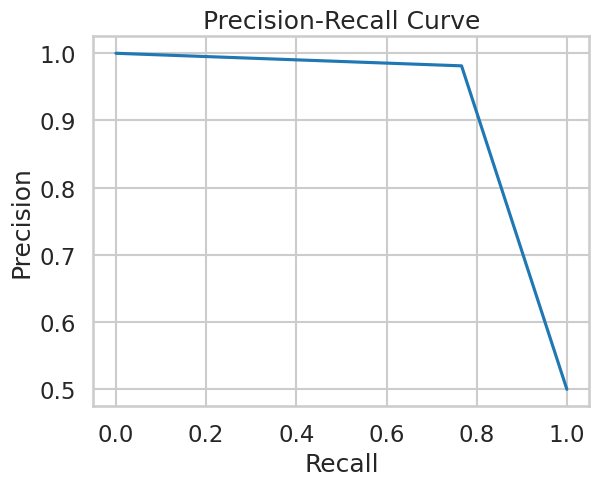

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Compute precision and recall
precision, recall, thresholds = precision_recall_curve(test_labels, y_pred)

# Plot the Precision-Recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

